In [1]:
pip install torchinfo

In [2]:


import torch
from torch import nn
import torchvision
from torchvision import transforms
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [4]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)


In [7]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [18]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        y = y.float()

        # 1. Forward pass
        y_pred = model(X).squeeze()

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        # turn logits -> pred probs -> pred labls

        # Calculate and accumulate accuracy metric across all batches
        # torch.eq() calculates where two tensors are equal
        correct = torch.eq(y, torch.round(torch.sigmoid(y_pred))).sum().item()
        train_acc += (correct / len(y)) * 100
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            y = y.float()
            # 1. Forward pass
            test_pred_logits = model(X).squeeze()
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            correct = torch.eq(y, torch.round(torch.sigmoid(test_pred_logits))).sum(
            ).item()  # torch.eq() calculates where two tensors are equal
            test_acc += (correct / len(y)) * 100

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if ((epoch == 5) or (epoch == 10)):
          save_filepath = f"lr001_efficientnet_100percent_{epoch}_epochs.pth"
          save_model(model=model,
                        target_dir="models",
                        model_name=save_filepath)
        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(16, 1, 224, 224).to(device))

    # Close the writer
    writer.close()


    # Return the filled results at the end of the epochs
    return results


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [11]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1),antialias=True )

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
train_dataset = torchvision.datasets.DatasetFolder(
    '/content/drive/MyDrive/pneumonia-detection/Processed/train/',
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    '/content/drive/MyDrive/pneumonia-detection/Processed/val/',
    loader=load_file, extensions="npy", transform=val_transforms)


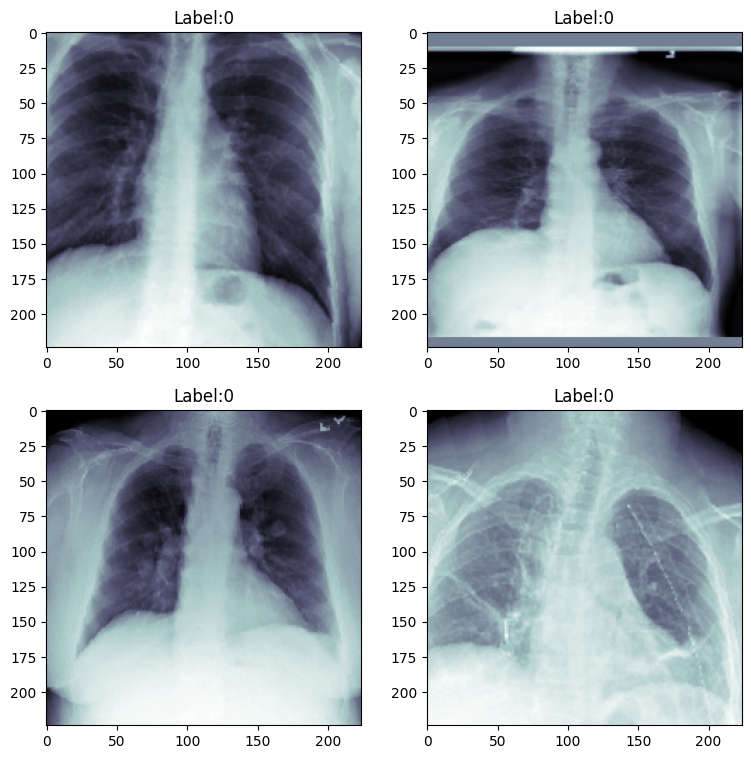

In [14]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 100)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")



In [25]:
batch_size = 64#TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,num_workers=2,  shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False,drop_last=True)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [26]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [17]:
# .DEFAULT = best available weights
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
print(model)

# Create a new input layer with the desired number of channels


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 206MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
model.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


In [20]:

model.classifier = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True),
  torch.nn.Linear(in_features=1280,
                  out_features=1, # same number of output units as our number of classes
                  bias=True)).to(device)

In [21]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(64, 1, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 1, 224, 224]    [64, 1]              --                   True
├─Sequential (features)                                      [64, 1, 224, 224]    [64, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 1, 224, 224]    [64, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [64, 1, 224, 224]    [64, 24, 112, 112]   216                  True
│    │    └─BatchNorm2d (1)                                  [64, 24, 112, 112]   [64, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [64, 24, 112, 112]   [64, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 24, 112, 112]   [64, 24, 112

In [22]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [23]:
# 1. Create epochs list
num_epochs = [15]
models = ["EfficientNetV2withTrainablelayers"]
train_dataloaders = {"100_Percent_Training_Images": train_loader}


In [27]:
%%time


# 1. Set the random seeds
set_seeds(seed=24)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")



            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]).to(device))
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

            # 9. Train target model with target dataloaders and track experiments
            results = train(model=model,
                  train_dataloader=train_loader,
                  test_dataloader=val_loader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"pos3lr0001_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: EfficientNetV2withTrainablelayers
[INFO] DataLoader: 100_Percent_Training_Images
[INFO] Number of epochs: 15
[INFO] Created SummaryWriter, saving to: runs/2023-09-25/100_Percent_Training_Images/EfficientNetV2withTrainablelayers/15_epochs...


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7534 | train_acc: 75.4042 | test_loss: 0.6526 | test_acc: 78.7348
Epoch: 2 | train_loss: 0.6892 | train_acc: 77.9500 | test_loss: 0.6251 | test_acc: 76.8293
Epoch: 3 | train_loss: 0.6595 | train_acc: 78.4125 | test_loss: 0.6038 | test_acc: 78.3537
Epoch: 4 | train_loss: 0.6369 | train_acc: 79.5958 | test_loss: 0.5969 | test_acc: 76.8293
Epoch: 5 | train_loss: 0.6162 | train_acc: 80.1958 | test_loss: 0.6120 | test_acc: 81.0595
Epoch: 6 | train_loss: 0.5974 | train_acc: 80.7208 | test_loss: 0.6111 | test_acc: 80.2210
[INFO] Saving model to: models/lr001_efficientnet_100percent_5_epochs.pth
Epoch: 7 | train_loss: 0.5814 | train_acc: 81.4500 | test_loss: 0.6193 | test_acc: 78.2012
Epoch: 8 | train_loss: 0.5542 | train_acc: 82.0458 | test_loss: 0.6039 | test_acc: 80.8308
Epoch: 9 | train_loss: 0.5344 | train_acc: 82.7500 | test_loss: 0.6235 | test_acc: 77.0579
Epoch: 10 | train_loss: 0.5140 | train_acc: 83.7000 | test_loss: 0.6583 | test_acc: 82.7744
Epoch: 11 | tra

In [ ]:
iterable = iter(train_loader)
img, lab = next(iterable)

In [28]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

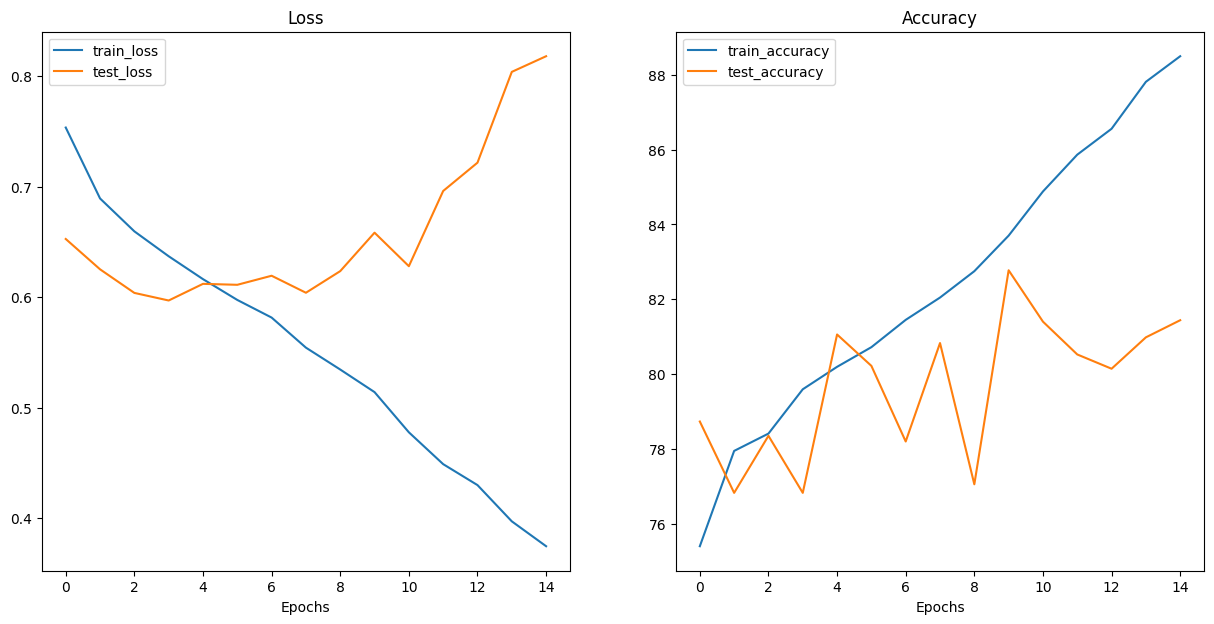

In [29]:
plot_loss_curves(results)

In [30]:
from torch import nn
import torchvision
from pathlib import Path
MODEL_PATH = Path("models/")
MODEL_NAME = "lr001_efficientnet_100percent_10_epochs.pth"
# 2. Create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Create a ResNet50 model.
loaded_model = torchvision.models.efficientnet_v2_s(pretrained=False)
loaded_model.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH,map_location=device))


# Set the model to evaluation mode.
loaded_model.eval()
loaded_model.to(device);

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(loaded_model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [32]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.9 MB/s eta 0:00:00


In [33]:
import torchmetrics

acc = torchmetrics.Accuracy(task='binary', threshold=0.5)(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary')(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', threshold=0.5)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.817064106464386
Val Precision: 0.5686746835708618
Val Recall: 0.7801653146743774
Confusion Matrix:
 tensor([[1721,  358],
        [ 133,  472]])
Confusion Matrix 2:
 tensor([[1721,  358],
        [ 133,  472]])


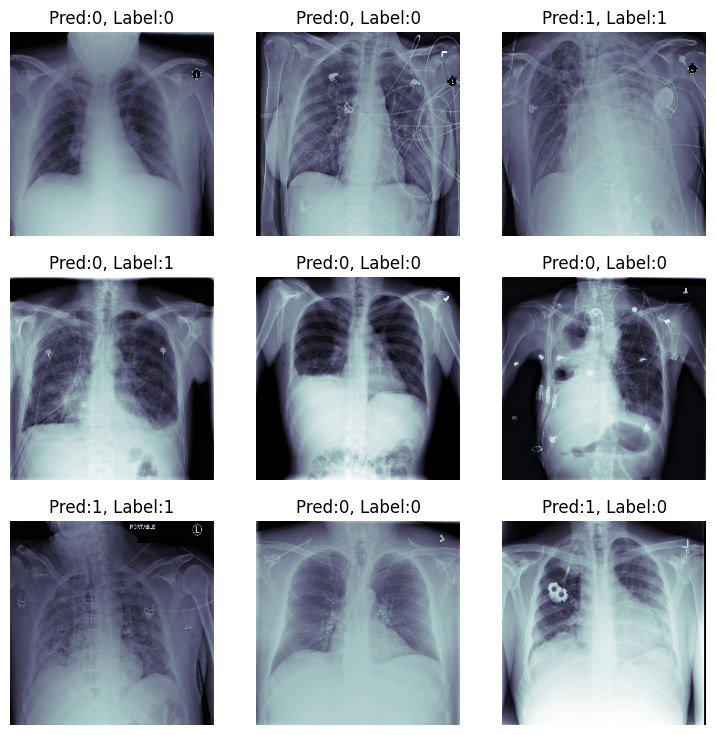

In [37]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

In [35]:
from torch import nn
import torchvision
from pathlib import Path
MODEL_PATH = Path("models/")
MODEL_NAME = "pos3lr0001_EfficientNetV2withTrainablelayers_100_Percent_Training_Images_15_epochs.pth"
# 2. Create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Create a ResNet50 model.
loaded_model = torchvision.models.efficientnet_v2_s(pretrained=False)
loaded_model.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH,map_location=device))


# Set the model to evaluation mode.
loaded_model.eval()
loaded_model.to(device);

cuda:0


In [36]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(loaded_model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
import torchmetrics

acc = torchmetrics.Accuracy(task='binary', threshold=0.5)(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary')(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', threshold=0.5)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")